In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import delayed, Parallel
from scipy.stats import zscore
from scipy import stats
from scipy.optimize import curve_fit
from utils.data_loader import DataLoader
from utils.plotting import plot_voxels, plot_w_fit
# from utils.relaxation_time import RelaxationTime
from PyIF import te_compute as te
import time

import warnings
warnings.filterwarnings('ignore')

/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [3]:
root_dir = '/scratch/shivansh.seth/adni/preproc'
dloader = DataLoader(root_dir)

In [3]:

ad_ts = dloader.get_func(dloader.subjects_list[1]).get_fdata()
ad_ts = ad_ts.reshape((-1, ad_ts.shape[-1]))

cn_ts = dloader.get_func(dloader.subjects_list[1]).get_fdata()
cn_ts = cn_ts.reshape((-1, cn_ts.shape[-1]))

# trunc_lim = min(ad_ts.shape[-1], cn_ts.shape[-1])
trunc_lim = 140

ad_ts = ad_ts[:, :trunc_lim]
cn_ts = cn_ts[:, :trunc_lim]


print(ad_ts.shape, cn_ts.shape)

(228939, 140) (228939, 140)


In [4]:
def compute_te(t1, t2, **kwargs):
    t1_z = zscore(t1)
    t2_z = zscore(t2)
    if np.any(np.isnan(t1_z)) or np.any(np.isnan(t2_z)):
        return 0
    return te.te_compute(t1_z, t2_z, **kwargs)

def calc_te_sr(timeseries, sig_rois):
    warnings.filterwarnings('ignore')
    stic = time.time()
    te_map = []
    k = 0
    for i in sig_rois:
        istic = time.time()
        
        res = Parallel(n_jobs=20)(
            delayed(compute_te)(timeseries[i], timeseries[j], embedding=1) 
            for j in sig_rois
        )
        res = Parallel(n_jobs=20)(
            delayed()(timeseries[i], timeseries[j], embedding=1) 
            for j in sig_rois
        )
        res = np.array(res)
        if np.all(res == 0):
            print(f'All NaNs for region {i}, {k}')
        k+=1
        te_map.append(res)
        
    print(f"Finished calc in {time.time()-stic} seconds")    
    return np.array(te_map)

def calc_te(timeseries, sig_rois):
    warnings.filterwarnings('ignore')
    stic = time.time()
    te_map = []
    k = 0
    for i in sig_rois:
        istic = time.time()
        
        res = Parallel(n_jobs=20)(
            delayed(compute_te)(timeseries[i], timeseries[j], embedding=1) 
            for j in timeseries.shape[0]
        )
        res = np.array(res)
        if np.all(res == 0):
            print(f'All NaNs for region {i}, {k}')
        print(f"{k}: Ran {i} in {time.time()-istic} seconds")
        k+=1
        te_map.append(res)
        
    print(f"Finished calc in {time.time()-stic} seconds")    
    return np.array(te_map)

In [6]:
ad_te_files = glob.glob('results/ad_te*')
cn_te_files = glob.glob('results/cn_te*')

sr = np.load('results/significant_regions_ss.npy')

In [15]:
ad_te_files

['results/ad_te_2.npy',
 'results/ad_te_6.npy',
 'results/ad_te_sr.npy',
 'results/ad_te_12.npy',
 'results/ad_te_13.npy',
 'results/ad_te_31.npy',
 'results/ad_te_11.npy',
 'results/ad_te_18.npy',
 'results/ad_te_20.npy',
 'results/ad_te_9.npy',
 'results/ad_te_3.npy']

## Z-scored SR-SR

In [ ]:
typical_subs_fp = "/home/shivansh.seth/phase_diagram_analysis/results/typical_subjects.npz"
with open(typical_subs_fp, 'rb') as f:
    typical_subs = np.load(f)
    ad_sub_idx = typical_subs['ad_sub_idx'][:10]
    cn_sub_idx = typical_subs['cn_sub_idx'][:10]
        
ad_te_sr = np.zeros((len(ad_sub_idx), len(sr), len(sr)))
cn_te_sr = np.zeros((len(cn_sub_idx), len(sr), len(sr)))

for idx, ad in enumerate(ad_sub_idx):
    print('AD sub:', ad)
    ad_ts = dloader.get_func(dloader.subjects_list[ad]).get_fdata()
    ad_ts = ad_ts.reshape((-1, ad_ts.shape[-1]))
    trunc_lim = 140
    ad_ts = ad_ts[:, :trunc_lim]
    print(ad_ts.shape)
    ad_te = calc_te_sr(ad_ts, sr)
    ad_te_sr[idx] = ad_te
    np.save(f"/home/shivansh.seth/phase_diagram_analysis/results/ad_te_{ad}.npy", ad_te)

# np.save(f"/home/shivansh.seth/phase_diagram_analysis/results/ad_te_sr.npy", ad_te_sr)

for idx, cn in enumerate(cn_sub_idx):
    print('CN sub:', cn)
    cn_ts = dloader.get_func(dloader.subjects_list[cn]).get_fdata()
    cn_ts = cn_ts.reshape((-1, cn_ts.shape[-1]))
    trunc_lim = 140
    cn_ts = cn_ts[:, :trunc_lim]
    print(cn_ts.shape)
    cn_te = calc_te_sr(cn_ts, sr)
    cn_te_sr[idx] = cn_te
    np.save(f"/home/shivansh.seth/phase_diagram_analysis/results/cn_te_{cn}.npy", cn_te)

# np.save(f"/home/shivansh.seth/phase_diagram_analysis/results/cn_te_sr.npy", cn_te_sr)

## Optimal delay calculation

In [103]:
import numpy as np
from sklearn.metrics import mutual_info_score

def discretize_continuous_time_series(x, threshold_percentile=0.5):
    std = np.std(x)
    thresholds = [-threshold_percentile, threshold_percentile]
    threshold_values = np.array(thresholds) * std
    x_discrete = np.zeros_like(x, dtype=int)
    x_discrete[x > threshold_values[1]] = 1
    x_discrete[x < threshold_values[0]] = -1
    return x_discrete

def mutual_information_delay(x, y, max_delay=None, threshold_percentile=0.5):
    if max_delay is None:
        max_delay = len(x)//2
    x_discrete = discretize_continuous_time_series(x, threshold_percentile)
    y_discrete = discretize_continuous_time_series(y, threshold_percentile)
    delay_scores = np.zeros(max_delay)
    for d in range(1, max_delay):
        x_delayed = x_discrete[d:]
        y_undelayed = y_discrete[:-d]
        delay_scores[d] = mutual_info_score(x_delayed, y_undelayed)
    delay = np.argmax(delay_scores) + 1
    return delay, delay_scores


In [88]:
def te_delay(x, y):
    max_delay = len(x)//2
    delay_vals = []
    for d in range(1, max_delay):
        x_delayed = x[d:]
        y_undelayed = y[:-d]
        delay_vals.append(te.te_compute(x_delayed, y_undelayed))
    delay = np.argmax(delay_vals) + 1
    return delay, delay_vals

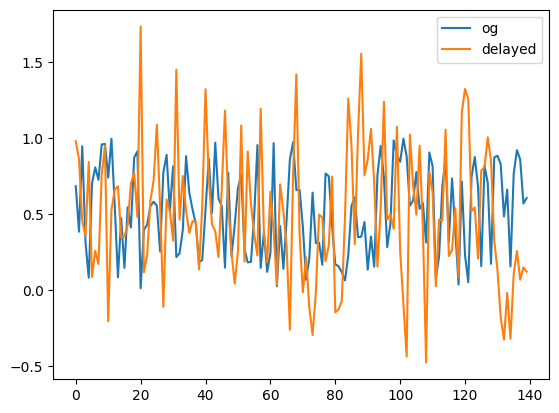

In [113]:
data = np.random.rand(140)
delay = 10
x = data
y = np.pad(data[delay:], (0, len(x) - len(data[delay:])), mode='constant') + np.random.normal(size=140, scale=0.3)

plt.plot(x, label='og')
plt.plot(y, label='delayed')
plt.legend()
plt.show()

In [8]:
(0.22523951530456543 * 220000*250)/(3600*32)

107.53622692492273

optimal delay: 9, time taken: 0.22523951530456543 sec


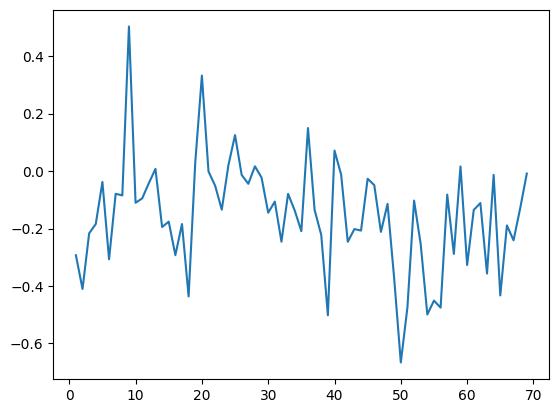

In [114]:
st_time = time.time()
d, vals = te_delay(x, y)
tt = time.time() - st_time

print(f"optimal delay: {d}, time taken: {tt} sec")
plt.plot(range(1, len(vals)+1), vals)

optimal delay: 11, time taken: 0.07520294189453125 sec


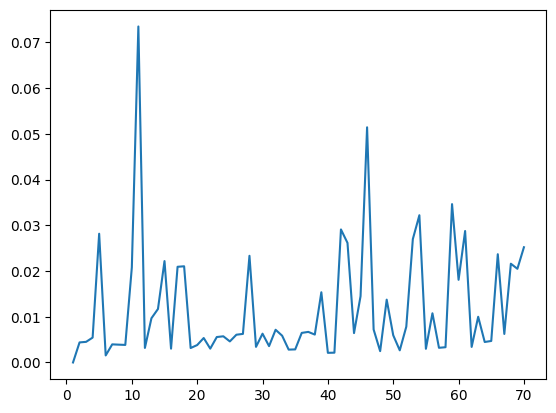

In [115]:
st_time = time.time()
d, vals = mutual_information_delay(x, y)
tt = time.time() - st_time
plt.plot(range(1, len(vals)+1), vals)
print(f"optimal delay: {d}, time taken: {tt} sec")

In [121]:
trails = 100
te_err = []
mi_err = []
te_time = []
mi_time = []
for t in range(trails): 
    print(f"Trial: {t}")
    data = np.random.rand(140)
    delay = np.random.randint(0, 50)
    x = data
    y = np.pad(data[delay:], (0, len(x) - len(data[delay:])), mode='constant') + np.random.normal(size=140, scale=0.3)
    st_time = time.time()
    d, vals = te_delay(x, y)
    tt = time.time() - st_time
    te_err.append(abs(delay - d))
    te_time.append(tt)
    st_time = time.time()
    d, vals = mutual_information_delay(x, y)
    tt = time.time() - st_time
    mi_err.append(abs(delay - d))
    mi_time.append(tt)

Trial: 0
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial: 30
Trial: 31
Trial: 32
Trial: 33
Trial: 34
Trial: 35
Trial: 36
Trial: 37
Trial: 38
Trial: 39
Trial: 40
Trial: 41
Trial: 42
Trial: 43
Trial: 44
Trial: 45
Trial: 46
Trial: 47
Trial: 48
Trial: 49
Trial: 50
Trial: 51
Trial: 52
Trial: 53
Trial: 54
Trial: 55
Trial: 56
Trial: 57
Trial: 58
Trial: 59
Trial: 60
Trial: 61
Trial: 62
Trial: 63
Trial: 64
Trial: 65
Trial: 66
Trial: 67
Trial: 68
Trial: 69
Trial: 70
Trial: 71
Trial: 72
Trial: 73
Trial: 74
Trial: 75
Trial: 76
Trial: 77
Trial: 78
Trial: 79
Trial: 80
Trial: 81
Trial: 82
Trial: 83
Trial: 84
Trial: 85
Trial: 86
Trial: 87
Trial: 88
Trial: 89
Trial: 90
Trial: 91
Trial: 92
Trial: 93
Trial: 94
Trial: 95
Trial: 96
Trial: 97
Trial: 98
Trial: 99


In [122]:
np.mean(mi_err), np.mean(te_err)

(4.84, 16.01)

In [123]:
np.mean(mi_time), np.mean(te_time)

(0.05628486394882202, 0.18530184984207154)

## With delay optimization

In [ ]:
def compute_te(t1, t2, **kwargs):
    t1_z = zscore(t1)
    t2_z = zscore(t2)
    if np.any(np.isnan(t1_z)) or np.any(np.isnan(t2_z)):
        return 0
    d, _ = mutual_information_delay(t1_z, t2_z)
    t1_z = t1_z[d:]
    return te.te_compute(t1_z, t2_z, **kwargs)

def calc_te_sr(timeseries, sig_rois):
    warnings.filterwarnings('ignore')
    stic = time.time()
    te_map = []
    k = 0
    for i in sig_rois:
        istic = time.time()
        
        res = Parallel(n_jobs=20)(
            delayed(compute_te)(timeseries[i], timeseries[j], embedding=1) 
            for j in sig_rois
        )
        res = np.array(res)
        if np.all(res == 0):
            print(f'All NaNs for region {i}, {k}')
        k+=1
        te_map.append(res)
        
    print(f"Finished calc in {time.time()-stic} seconds")    
    return np.array(te_map)

## Original TEs

In [4]:
ad_te_files = glob.glob("/scratch/shivansh.seth/ad_te/*")
cn_te_files = glob.glob("/scratch/shivansh.seth/cn_te/*")

In [7]:
sk = np.load('skull_indices_flat.npy')
len(sk)

31569

In [8]:
ad_te_sr = np.zeros((len(ad_te_files), len(sr), len(sk)))
cn_te_sr = np.zeros((len(cn_te_files), len(sr), len(sk)))
ad_te_sum = np.zeros((len(ad_te_files), len(sr)))
cn_te_sum = np.zeros((len(cn_te_files), len(sr)))

In [9]:
for idx, ad in enumerate(ad_te_files):
    te = np.load(ad)
    print(te.shape)
#     if te.shape[1] > len(sr):
#         ad_te_sr[idx] = te[:, sr]
#     else: ad_te_sr[idx] = te
    ad_te_sr[idx] = te
    ad_te_sum[idx] = np.mean(te, axis=1)
np.save('results/ad_te_ss', ad_te_sr)
np.save('results/ad_te_mean_ss', ad_te_sum)

(222, 31569)
(222, 31569)
(222, 31569)
(222, 31569)
(222, 31569)
(222, 31569)
(222, 31569)
(222, 31569)
(222, 31569)
(222, 31569)


In [10]:
for idx, cn in enumerate(cn_te_files):
    te = np.load(cn)
    cn_te_sr[idx] = te
    cn_te_sum[idx] = np.mean(te, axis=1)
np.save('results/cn_te_ss', cn_te_sr)
np.save('results/cn_te_mean', cn_te_sum)